# Importing libraries:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import h5py

In [0]:
from keras import models
from keras import layers

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, BatchNormalization, Activation, Conv2DTranspose, Add, ZeroPadding2D, Cropping2D, UpSampling2D

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras.backend import argmax
from keras.utils import to_categorical

Using TensorFlow backend.


# Importing data:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 def load_h5(path):
	print('loading',path)
	file = h5py.File(name=path,mode='r')
	return file['images'],file['labels']
  

def load_train_data(path='/content/drive/My Drive/NNproject/voc2012_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        return load_h5(path)

def load_val_data(path='/content/drive/My Drive/NNproject/voc2012_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        return load_h5(path)

In [0]:
train_images, train_labels = load_train_data()
val_images, val_labels = load_val_data()

np.set_printoptions(threshold=np.inf)

loading /content/drive/My Drive/NNproject/voc2012_train.h5
loading /content/drive/My Drive/NNproject/voc2012_val.h5


# Pre-processing:

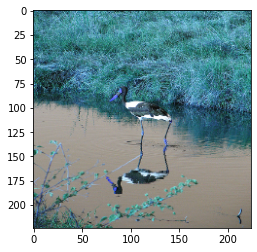

(1464, 224, 224)


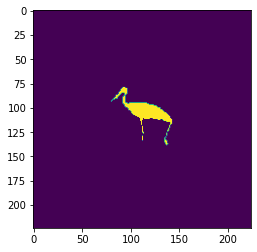

In [0]:
train_images=np.asarray(train_images)
train_labels=np.asarray(train_labels)
val_images=np.asarray(val_images)
val_labels=np.asarray(val_labels)

# print(val_labels[100])

plt.figure()
plt.imshow(train_images[1200])
plt.show() 
plt.imshow(train_labels[1200])
print(train_labels.shape)

Normalize the input pixels:

In [0]:
train_images = train_images/255
val_images = val_images/255

OneHot encoding:

In [0]:
from keras.utils import to_categorical
y_trn= to_categorical(train_labels, num_classes=21)
y_val= to_categorical(val_labels, num_classes=21)

In [0]:
print(y_trn.shape)

(1464, 224, 224, 21)


The 4th axis of the labelled tensors refer to the 21 classes in our problem.

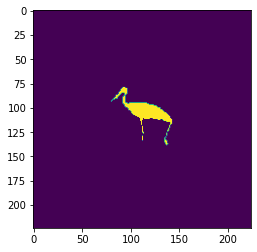

In [0]:
# Check that the encoding is correct:
plt.figure()
plt.imshow(np.argmax(y_trn[1200], axis=2))
plt.show()

# Model:

In [0]:
num_classes=21

base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
base_model.trainable=False

new_model = Sequential()

new_model.add(base_model)
new_model.add(Conv2D(4096, (7, 7), activation='tanh',
                padding='same'))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Dropout(0.5))
new_model.add((Conv2D(4096, (1, 1), activation='tanh',
                padding='same')))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Dropout(0.5))
new_model.add(Conv2D(num_classes,  (1, 1), kernel_initializer='he_normal'))
new_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
new_model.add(Conv2DTranspose(num_classes, kernel_size=(32, 32),  strides=(32, 32), use_bias=False))
new_model.add(Activation('softmax'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 4096)        102764544 
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 4096)        16384     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 4096)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4096)        16781312  
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 4096)        16384     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 4096)       

In [0]:
opt = Adam(lr=0.001)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
epochs = 100
steps_per_epoch = 80
new_model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = new_model.fit(train_images, y_trn, validation_data=(val_images, y_val), epochs=epochs, verbose=True, batch_size=20)

Train on 1464 samples, validate on 1449 samples
Epoch 1/100
1464/1464 [==============================] - 115s 79ms/step - loss: 2.7372 - categorical_accuracy: 0.5658 - val_loss: 1.6788 - val_categorical_accuracy: 0.7295
Epoch 2/100
1464/1464 [==============================] - 102s 70ms/step - loss: 1.9700 - categorical_accuracy: 0.7025 - val_loss: 1.2656 - val_categorical_accuracy: 0.7339
Epoch 3/100
1464/1464 [==============================] - 102s 70ms/step - loss: 1.4733 - categorical_accuracy: 0.7353 - val_loss: 1.4773 - val_categorical_accuracy: 0.7111
Epoch 4/100
1464/1464 [==============================] - 102s 69ms/step - loss: 1.2824 - categorical_accuracy: 0.7443 - val_loss: 1.8104 - val_categorical_accuracy: 0.6945
Epoch 5/100
1464/1464 [==============================] - 102s 69ms/step - loss: 1.2074 - categorical_accuracy: 0.7497 - val_loss: 2.2856 - val_categorical_accuracy: 0.6297
Epoch 6/100
1464/1464 [==============================] - 102s 70ms/step - loss: 1.1742 - cat

The training accuracy is 93%.
The validation accuracy is 80%.

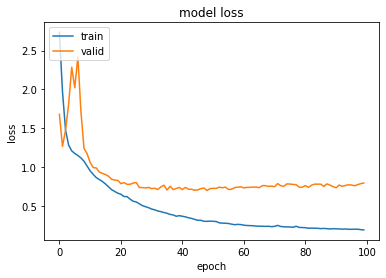

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

Saving the model..

In [0]:
from keras.models import model_from_json
from keras.models import load_model


model_json = new_model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
new_model.save_weights("model_num.h5")

Loading the model next time:

In [0]:
json_file = open('model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_num.h5")
print("Loaded model from disk")

loaded_model.save('model_num.hdf5')
loaded_model=load_model('model_num.hdf5')

Loaded model from disk


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Predict some samples after training is complete:

In [0]:
def show_result(img, index):

  x=img.reshape(1,224,224,3)

  d =new_model.predict(x)

  imclass = np.argmax(d, axis=3)[0,:,:]

  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1)
  plt.imshow( np.asarray(img) )
  plt.subplot(1,3,2)
  plt.imshow( np.asarray(img) )
  masked_imclass = np.ma.masked_where(imclass == 0, imclass)
  plt.imshow( masked_imclass, alpha=0.5 )
  
  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1, title='Our target')
  plt.imshow( val_labels[index] )
  plt.subplot(1,3,2, title='Our prediction')
  plt.imshow( imclass )

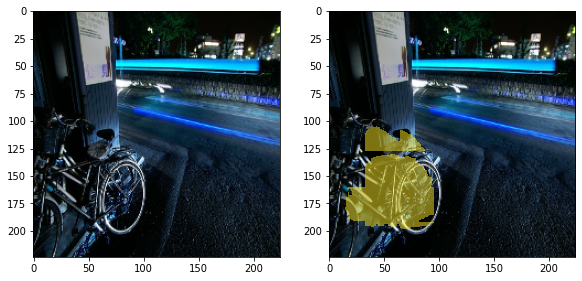

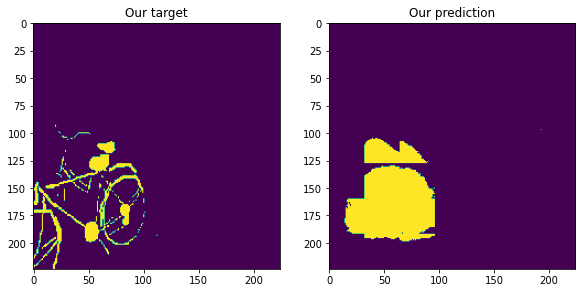

In [154]:
show_result(val_images[15], 15)

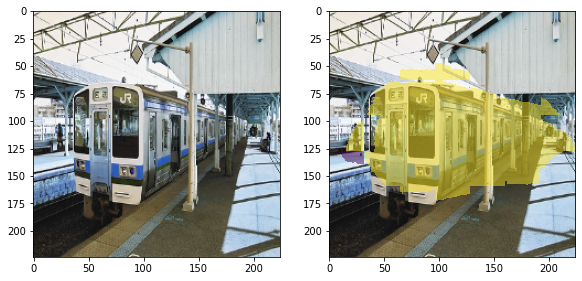

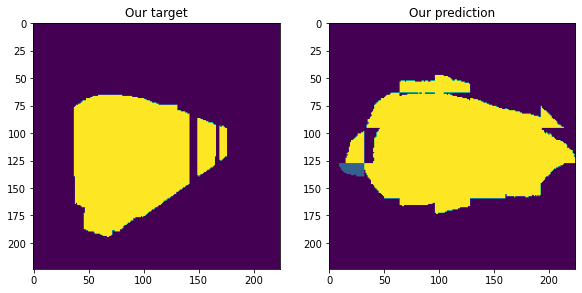

In [155]:
show_result(val_images[17], 17)

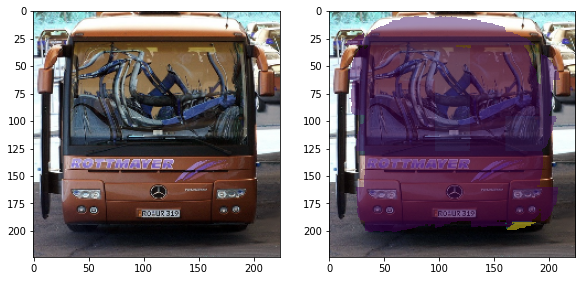

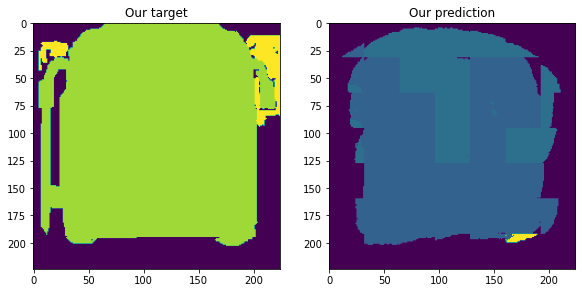

In [157]:
show_result(val_images[19], 19)

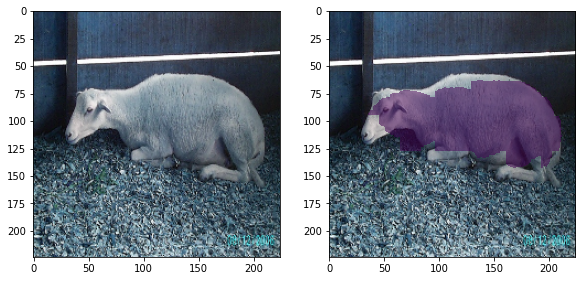

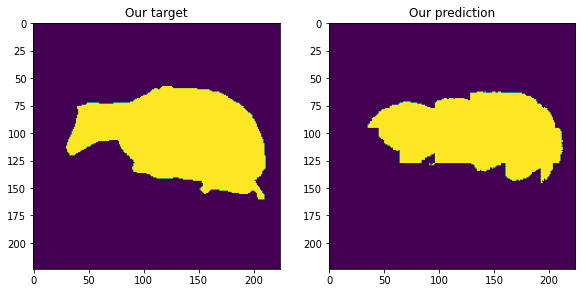

In [159]:
show_result(val_images[20], 20)

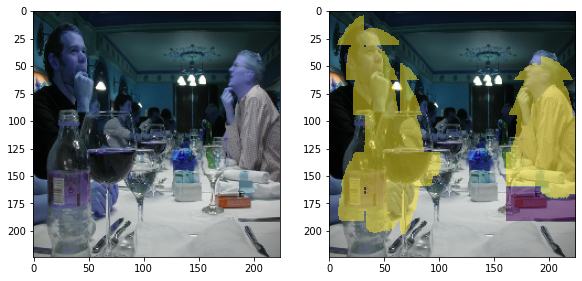

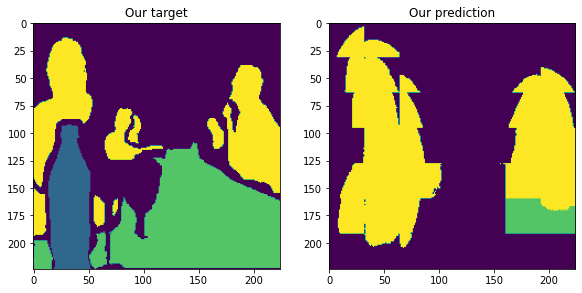

In [160]:
show_result(val_images[22], 22)

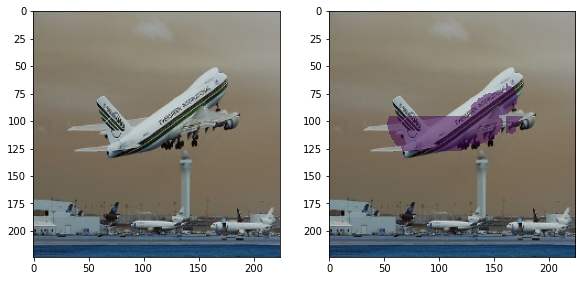

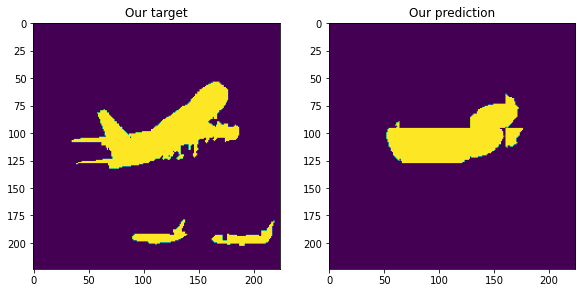

In [161]:
show_result(val_images[36], 36)

# If you would like to test on an imported image:

In [178]:
img=cv2.imread('test.jpg')     # enter the path directory of the image to load it to the notebook
img.shape         # Check that the size is (224, 224, 3) .. if not then resize using the following line of code

(1500, 1125, 3)

In [179]:
resized_img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resized_img.shape

(224, 224, 3)

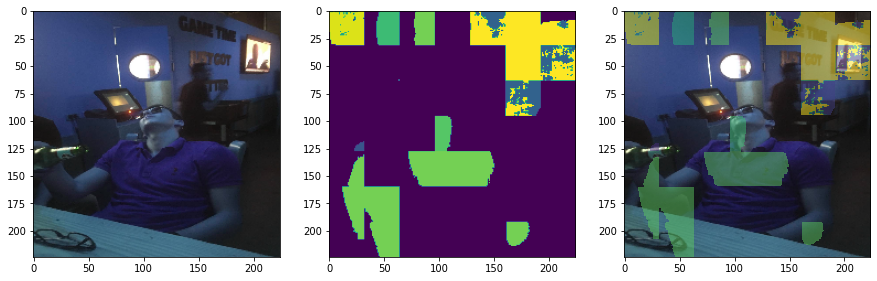

In [181]:
def test(img):
  x=img.reshape(1,224,224,3)

  d =new_model.predict(x)

  imclass = np.argmax(d, axis=3)[0,:,:]

  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1)
  plt.imshow( np.asarray(img) )
  plt.subplot(1,3,2)
  plt.imshow( imclass )
  plt.subplot(1,3,3)
  plt.imshow( np.asarray(img) )
  masked_imclass = np.ma.masked_where(imclass == 0, imclass)
  #plt.imshow( imclass, alpha=0.5 )
  plt.imshow( masked_imclass, alpha=0.5 )

test(resized_img)

that was a difficult test image anyway :)